# Download Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path)

100%|██████████| 750M/750M [00:32<00:00, 24.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [3]:
import os

# Set file path to dataset images
fpath = "/root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images"

# Select categories (limiting to 20 for faster processing)
categories = os.listdir(fpath)[:20]
print("List of categories = ", categories, "\n\nNo. of categories = ", len(categories))

List of categories =  ['n02108915-French_bulldog', 'n02108551-Tibetan_mastiff', 'n02093859-Kerry_blue_terrier', 'n02112350-keeshond', 'n02089078-black-and-tan_coonhound', 'n02099712-Labrador_retriever', 'n02106166-Border_collie', 'n02110627-affenpinscher', 'n02088238-basset', 'n02101556-clumber', 'n02106550-Rottweiler', 'n02091134-whippet', 'n02111129-Leonberg', 'n02096177-cairn', 'n02091467-Norwegian_elkhound', 'n02098413-Lhasa', 'n02101006-Gordon_setter', 'n02113624-toy_poodle', 'n02085782-Japanese_spaniel', 'n02108089-boxer'] 

No. of categories =  20


# Import Library

In [4]:
import os
import cv2
import numpy as np
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import Dataset, DataLoader

# Data Processing and Transformation

In [5]:
class DogsDataset(Dataset):
    def __init__(self, categories, fpath, transform=None):
        self.categories = categories
        self.fpath = fpath
        self.transform = transform
        self.data = []
        self.labels = []

        # Preprocess data: Load image paths and labels
        for index, category in enumerate(categories):
            category_path = os.path.join(fpath, category)
            for image_name in os.listdir(category_path):
                image_path = os.path.join(category_path, image_name)
                self.data.append(image_path)
                self.labels.append(index)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label

In [6]:
# Define transformations for resizing and normalization
transform = Compose([
    ToTensor(),  # Convert images to PyTorch tensors
    Resize((227, 227)),  # Resize images to 227x227 for AlexNet compatibility
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Create dataset
dataset = DogsDataset(categories, fpath, transform)

# Train Test Split

In [7]:
from torch.utils.data import random_split
# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}")

Train dataset size: 2696, Test dataset size: 675


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Show 9 random example image

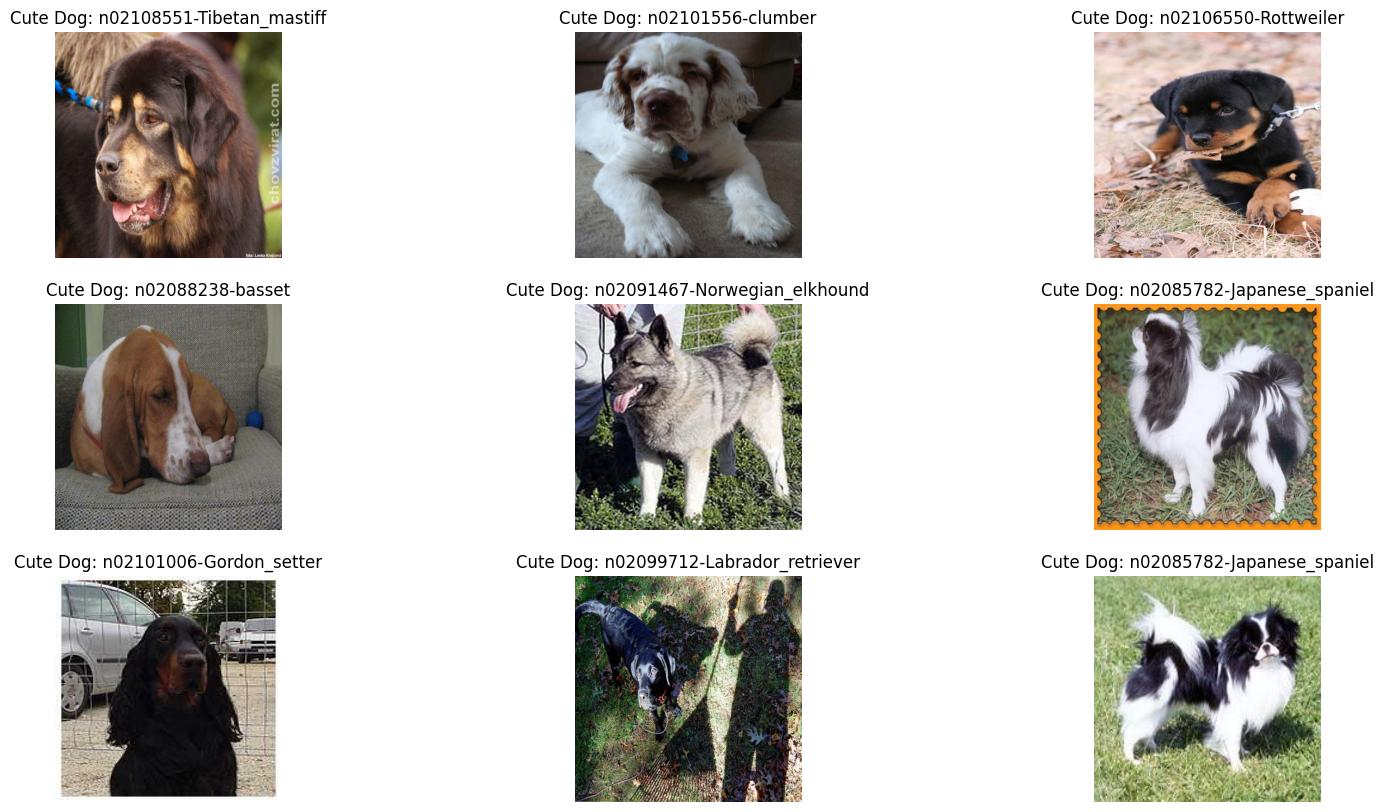

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display random images
def display_rand_images(dataset, categories):
    plt.figure(figsize=(19, 10))
    for i in range(9):
        idx = np.random.randint(0, len(dataset))  # Pick a random index
        img, label = dataset[idx]  # Get the image and label
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to HWC format
        img = (img * 0.5 + 0.5).clip(0, 1)  # De-normalize image (reverse the normalization)

        plt.subplot(3, 3, i + 1)  # 3x3 grid of images
        plt.imshow(img)  # Display the image
        plt.title(f"Cute Dog: {categories[label]}")  # Display the category of the dog
        plt.axis("off")  # Turn off the axis

    plt.show()

# Visualize images from the training dataset
display_rand_images(train_dataset, categories)


# Define Neural Network

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define a simple neural network using a pretrained AlexNet model
import torch
import torch.nn as nn
import torch.nn.functional as F

class DogsCNN(nn.Module):
    def __init__(self, num_classes):
        super(DogsCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels (RGB), 32 output channels
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after convolution
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 kernel

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        # Calculate the size of the feature map after the last pooling layer
        self._to_linear = None
        self.convs = nn.Sequential(self.conv1, self.bn1, self.pool1,
                                   self.conv2, self.bn2, self.pool2,
                                   self.conv3, self.bn3, self.pool3,
                                   self.conv4, self.bn4, self.pool4)
        self._get_to_linear(227)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 1024)  # Reduced size
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def _get_to_linear(self, size):
        # Pass a dummy input through the convolution layers to get the output size
        x = torch.randn(1, 3, size, size)
        x = self.convs(x)
        self._to_linear = x.numel()  # Get the flattened size of the output
        print("Flattened size:", self._to_linear)

    def forward(self, x):
        # Convolution blocks
        x = self.convs(x)

        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the available device (GPU/CPU)
model = DogsCNN(num_classes=len(categories)).to(device)

print(f"Model is on {device}")

Flattened size: 50176
Model is on cpu


# Define Loss Function, Optimizer, and DataLoader

In [10]:
import torch.nn.functional as F

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # Adam optimizer

# Move data to the same device as the model (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the training loop
def train(model, train_loader, criterion, optimizer, device, num_epochs=5):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device
            optimizer.zero_grad()  # Zero out gradients from previous step
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update model parameters

            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_predictions
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    print("Training complete.")

In [11]:
# Train the model using the train_loader
train(model, train_loader, criterion, optimizer, device, num_epochs=10)

Epoch [1/10], Loss: 2.9288, Accuracy: 9.53%
Epoch [2/10], Loss: 2.7671, Accuracy: 15.24%
Epoch [3/10], Loss: 2.6534, Accuracy: 18.32%
Epoch [4/10], Loss: 2.5717, Accuracy: 20.62%
Epoch [5/10], Loss: 2.5045, Accuracy: 23.33%
Epoch [6/10], Loss: 2.4069, Accuracy: 25.70%
Epoch [7/10], Loss: 2.3546, Accuracy: 28.71%
Epoch [8/10], Loss: 2.2667, Accuracy: 31.42%
Epoch [9/10], Loss: 2.2230, Accuracy: 32.90%
Epoch [10/10], Loss: 2.1553, Accuracy: 33.75%
Training complete.


# Save the model

In [13]:
# Save the model using torch.save
torch.save(model.state_dict(), "dogs_cnn_model.pth")

In [14]:
# Load the model using torch.load
model = DogsCNN(num_classes=len(categories))  # Recreate the model architecture
model.load_state_dict(torch.load("dogs_cnn_model.pth"))
model.to(device)
model.eval()

Flattened size: 50176


<ipython-input-14-34bc2507710f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dogs_cnn_model.pth"))


DogsCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [15]:
import torch

# Example: Save the PyTorch model
model_save_path = "dogs_cnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at: {model_save_path}")


Model saved at: dogs_cnn_model.pth


In [16]:
from google.colab import files

# Download the saved model file
files.download("dogs_cnn_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>